---
# Molecular Dynamics Simulations in Python
---

## 1. Introduction <a id='l_overview'></a>

Adapted from https://github.com/klyshko/md_python/blob/master/Lecture.ipynb

The goal of this activity is to run a simple Molecular Dynamics (MD) simulation of macromolecules. We will learn how to run these simulations using the Python programmming language with the Python module `openmm`. This whole "Notebook" will guide you through setting up and running a simulation, and performing some simple analysis to help you understand what might be happening during your simulation.

Questions to think about:
- What happens to the end-to-end distance of your molecule during the simulation?
- Are there any important structures that emerge in the Ramachandran plot?
- What happens if you change the temperature of the simulation?

First, here's some sections on why and how we use MD. This isn't mandatory reading, but may be of interest. If you want to skip straight to the activity, you can go straight to [MD Simulations of Proteins](#l_md) below.

- [Newton's Laws of Motion](#l_newton) 
- [Proteins -- Different Levels of Structure](#l_proteins)
- [Molecular Mechanics](#l_mm)
- [MD Simulations of Proteins](#l_md)


## 2. Newton's Laws of Motion <a id='l_newton'></a>

Newton's 2nd law connects the kinematics (movements) of a body with its mechanics (total force acting on it) and defines the dynamic evolution of its position: 

$$m\frac{d^2r(t)}{dt^2} = F = - \nabla{U(r)},$$

where $m$ is the mass, $r$ is the position, $F$ is the force and $U(r)$ is the potential energy, which depends only on the position of the body. 
If one knows the forces acting upon the body, one can find the position of the body at any moment $r(t)$, i.e. predict its dynamics. This can be done by solving Newton's equation of motion. It is a second order ODE that can be solved analytically for a few simple cases: constant force, harmonic oscillator, periodic force, drag force, etc.
However, a more general approach is to use computers in order to solve the ODE numerically.

While we now have a basic knowledge of the purpose and methodology of simulations, we still need to understand what proteins are and why they are important.

---
## 3. Proteins, structure and functions <a id='l_proteins'></a>
---
<img src="pics/Protein_structure.png" width="400" align="right">

[Protein structure](https://en.wikipedia.org/wiki/Protein_structure) is the three-dimensional arrangement of atoms in a protein, which is a chain of amino acids. Proteins are polymers – specifically polypeptides – formed from sequences of 20 types of amino acids, the monomers of the polymer. A single amino acid monomer may also be called a residue, indicating a repeating unit of a polymer. To be able to perform their biological function, proteins fold into one or more specific spatial conformations driven by a number of non-covalent interactions such as:

- hydrogen bonding 
- ionic interactions 
- Van der Waals forces
- hydrophobic packing 

To understand the functions of proteins at a molecular level, it is often necessary to determine their three-dimensional structure using techniques such as X-ray crystallography, NMR spectroscopy, and others.

### 3.1 Levels of structure:

**Primary structure** of a protein refers to the sequence of amino acids in the polypeptide chain.

**Secondary structure** refers to highly regular local sub-structures of the actual polypeptide backbone chain. There are two main types of secondary structure: the α-helix and the β-strand or β-sheets.

**Tertiary structure** refers to the three-dimensional structure of monomeric and multimeric protein molecules. The α-helixes and β-sheets are folded into a compact globular structure. 

**Quaternary structure** is the three-dimensional structure consisting of two or more individual polypeptide chains (subunits) that operate as a single functional unit (multimer).


### 3.2 Functions:

- *Antibodies* - bind to specific foreign particles, ex: IgG 
- *Enzymes* - speed up chemical reactions, ex: Lysozyme
- *Messengers* - transmit signals, ex: Growth hormone 
- *Structural components* - support for cells, ex: Tubulin
- *Transport/storage* - bind and carry small molecules, ex: Hemoglobin


**Lysozyme** is a protein-enzyme (found in tears, saliva, mucus and egg white) that is a part of the innate immune system with antimicrobial activity characterized by the ability to damage the cell wall of bacteria. Bacteria have polysaccharides (sugars) in their cell wall, that bind to the groove, and lysozyme cuts the bond and destroys bacteria.  

|  ![Protein Sequence in DNA](pics/LysozymeSequence.png) | ![Protein Structure](pics/LysozymeStructure.gif) | ![Protein Strucure with Sugar](pics/LysozymeRock.gif) |
|:-:|:-:|:-:|
|  Sequence | Structure | Function  |

Figure credit: [C.Ing](https://github.com/cing/HackingStructBiolTalk) and [wikipedia](https://en.wikipedia.org/wiki/Protein_structure)


---
## 4. Molecular Mechanics <a id='l_mm'></a>
---

Since we now know what proteins are and why these molecular machines are important, we consider the method to model them. Our system consists of thousands particles (atoms of the protein plus atoms of surrounding water) and they all are connected via a complex potential energy function.

An all-atom potential energy function $V$ is usually given by the sum of the bonded terms ($V_b$) and non-bonded terms ($V_{nb}$), i.e.

$$V = V_{b} + V_{nb},$$

where the bonded potential includes the harmonic (covalent) bond part, the harmonic angle and
the two types of torsion (dihedral) angles: proper and improper. As it can be seen, these functions are mostly harmonic potentials 

$$V_{b} = \sum_{bonds}\frac{1}{2}K_b(b-b_0)^2 + \sum_{angles}K_{\theta}(\theta-\theta_0)^2 + \sum_{dihedrals}K_{\phi}(1-cos(n\phi - \phi_0)) + \sum_{impropers}K_{\psi}(\psi-\psi_0)^2$$

For example, $b$ and $\theta$ represent the distance between two atoms and the angle between two
adjacent bonds; $\phi$ and $\psi$ are dihedral (torsion) angles. These can be evaluated for all the
atoms from their current positions. Also, $K_b$, $K_\theta$, $K_\phi$, and $K_\psi$ are the spring constants, associated
with bond vibrations, bending of bond angles, and conformational fluctuations in dihedral and
improper angles around some equilibrium values $b_0$, $\theta_0$, $\phi_0$, and $\psi_0$, respectively. 

The non-bonded part of the potential energy function is represented by the electrostatic and van der Waals potentials, i.e.

$$V_{nb} = \sum_{i,j}\left(\frac{q_{i}q_{j}}{4\pi\varepsilon_{0}\varepsilon r_{ij}} + \varepsilon_{ij}\left[\left(\frac{\sigma^{min}_{ij}}{r_{ij}}\right)^{12}-2\left(\frac{\sigma^{min}_{ij}}{r_{ij}}\right)^{6}\right]\right)$$

where $r_{ij}$ is the distance between two interacting atoms, $q_i$ and $q_j$ are their electric charges; $\varepsilon$ and
$\varepsilon_0$ are electric and dielectric constant; $\varepsilon_{ij} = \sqrt{\varepsilon_i\varepsilon_j}$ and
$\sigma_{ij} = \frac{\sigma_i + \sigma_j}{2}$ are van der Waals parameters for atoms $i$ and $j$.

**Importantly, each force field has its own set of parameters, which are different for different types of atoms.**

![](pics/ff.png)


## 5. Molecular dynamics of proteins <a id='l_md'></a>
---

[**Molecular dynamics (MD)**](https://en.wikipedia.org/wiki/Molecular_dynamics) is a computer simulation method for studying the physical movements of atoms and molecules, i.e. their dynamical evolution. 

In the most common version, the trajectories of atoms and molecules are determined by numerically solving Newton's equations of motion for a system of interacting particles, where forces between the particles and their potential energies are often calculated using  [molecular mechanics force fields](#l_mm). 



Now with all that intellectual equipment, we can start running legit Molecular Dynamics simulations. All we need is an initial structure of the protein and software that computes its dynamics efficiently.


### Procedure:
1. Load initial coordinates of protein atoms (from `*.pdb` file).
2. Choose force field parameters.
3. Choose parameters of the experiment: temperature, pressure, box size, solvation, boundary conditions.
4. Choose integrator, i.e. algorithm for solving equation of motion.
5. Run simulation, save coordinates time to time (to `*.dcd` file).
6. Visualize the trajectory.
7. Perform the analysis.

These are the Python libraries we are going to need today:

1. [nglview](http://nglviewer.org/nglview/latest/index.html#installation) - module to visualize molecules
2. [mdanalysis](https://www.mdanalysis.org/pages/installation_quick_start/) - module to analyze MD trajectory
3. [openmm](http://docs.openmm.org/latest/userguide/application.html#installing-openmm) - module to run MD simulation

To run the simulation, click on each cell (box) in turn and click the **Run** button (or press `shift+Return` on your keyboard). Each cell has finished running when the * symbol turns to a number. You don't need to write any code for this exercise! 

In [1]:
from openmm.app import *
from openmm import *
from simtk.unit import *
import MDAnalysis as md
import nglview as ng
import numpy as np
from sys import stdout
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter("ignore")

These files are already preloaded to a folder called `data`.

In [2]:
pdb0_file = 'data/villin_water.pdb'
pdb1_file = 'data/polyALA.pdb'
pdb2_file = 'data/polyGLY.pdb'
#pdb3_file = 'data/YOURNAME.pdb' # only works for some of you, I couldn't get it to work for everyone :(

PDB files contain 3D structures of proteins that were resolved by experimental techniques. They can be downloaded from [ProteinDataBank](https://www.wwpdb.org/). Here we can see what a `.pdb` file looks like - remember our activity last week, where we looked at `.pdb` files? In this cell, we're loading the structure of [Villin](https://en.wikipedia.org/wiki/Villin), which is an actin binding protein expressed mainly in the brush border of the epithelium in vertebrates.

In [3]:
file0 = open(pdb0_file, 'r')
counter = 0
for line in file0:
    if counter < 10:
        print(line)
    counter += 1

REMARK    GENERATED BY TRJCONV

HEADER    Villin N68H in explicit water

REMARK    THIS IS A SIMULATION BOX

CRYST1   49.163   45.981   38.869  90.00  90.00  90.00 P 1           1

MODEL        0

ATOM      1  N   LEU     1      25.160  14.160  19.440  1.00  0.00

ATOM      2  H1  LEU     1      24.350  13.730  19.870  1.00  0.00

ATOM      3  H2  LEU     1      25.980  13.680  19.760  1.00  0.00

ATOM      4  H3  LEU     1      25.180  15.100  19.810  1.00  0.00

ATOM      5  CA  LEU     1      25.090  13.920  17.980  1.00  0.00



We can look at the protein via `nglview`:

n.b. You might get a "Warning" when you run this cell - don't worry about it, you can ignore it and it won't affect your simulation.

In [4]:
u = md.Universe(pdb0_file)
ng.show_mdanalysis(u, gui=True)

NGLWidget()

### Activity: MD simulation of protein folding into alpha-helix
---

Run a simulation of fully extended polyalanine `polyALA.pdb` for 200 picoseconds in a vacuo environment with T=300 K and see if it can fold to any secondary  structure. First, let's open `polyALA.pdb` so we can see what it looks like before we run a simulation.

In [5]:
u = md.Universe(pdb1_file)
ng.show_mdanalysis(u, gui=True)

NGLWidget()

Now let's simulate it folding!

In [8]:
### 1.loading initial coordinates
pdb = PDBFile(pdb1_file) 

### 2.choosing a forcefield parameters
ff = ForceField('amber10.xml') 
#ff = ForceField('charmm36.xml')  # use this force field instead if you're running a PDB file I've made!
system = ff.createSystem(pdb.topology, nonbondedMethod=CutoffNonPeriodic)

### 3. Choose parameters of the experiment: temperature, pressure, box size, solvation, boundary conditions, etc
temperature = 300*kelvin
frictionCoeff = 1/picosecond
time_step = 0.002*picoseconds
total_steps = 200*picoseconds / time_step

### 4. Choose an algorithm (integrator)
integrator = LangevinIntegrator(temperature, frictionCoeff, time_step)

### 5. Run simulation, saving coordinates time to time:

### 5a. Create a simulation object
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

### 5b. Minimize energy
simulation.minimizeEnergy()

### 5c. Save coordinates to dcd file and energies to a standard output console:
simulation.reporters.append(DCDReporter('data/polyALA_traj.dcd', 1000))
simulation.reporters.append(StateDataReporter(stdout, 5000, step=True, potentialEnergy=True,\
                                              temperature=True, progress=True, totalSteps = total_steps))

### 5d. Run!
simulation.step(total_steps)

print("Simulation complete!")

#"Progress (%)","Step","Potential Energy (kJ/mole)","Temperature (K)"
5.0%,5000,5149.912109375,276.5800504814996
10.0%,10000,5260.07421875,300.0733877301387
15.0%,15000,5270.94580078125,317.10339279176503
20.0%,20000,5283.2060546875,284.7728120227239
25.0%,25000,5178.3671875,287.32653112662433
30.0%,30000,5243.642578125,291.8632165529862
35.0%,35000,5087.9580078125,278.2455275946798
40.0%,40000,5172.3115234375,296.45928458076173
45.0%,45000,5136.03955078125,277.5702158611792
50.0%,50000,5020.16650390625,309.15770397723514
55.0%,55000,5006.12548828125,307.5153633514348
60.0%,60000,5067.3701171875,294.9438749853179
65.0%,65000,5005.2392578125,315.5921592606603
70.0%,70000,5060.453125,303.33043443626957
75.0%,75000,4878.083984375,317.5728977207086
80.0%,80000,4874.7001953125,301.67086383821686
85.0%,85000,4940.88720703125,256.8182764069782
90.0%,90000,4899.4384765625,263.26403008431834
95.0%,95000,4859.46923828125,308.32758669743015
100.0%,100000,4819.33935546875,297.40625564715634
Simula

**Visualization**

Let's look at the trajectory:

In [9]:
### 6. Visualization
sys = md.Universe(pdb1_file, 'data/polyALA_traj.dcd')
ng.show_mdanalysis(sys, gui=True)

NGLWidget(max_frame=99)

### Activity: Analysis of MD trajectory.
---

**End-to-end distance**:

In [10]:
### analysis of end-to-end distance

## choose terminal atoms 
N_terminus = sys.select_atoms('resid 1 and name N')
C_terminus = sys.select_atoms('resid 25 and name C')

## go through the whole trajectory and compute distance between them for every frame
dist = []
for frame in sys.trajectory:
    dist.append(np.linalg.norm(N_terminus.positions - C_terminus.positions))

## the result is in the dist array    
dist = np.array(dist) 

print("Calculation completed!")

Calculation completed!


We can plot end-to-end distance vs time:

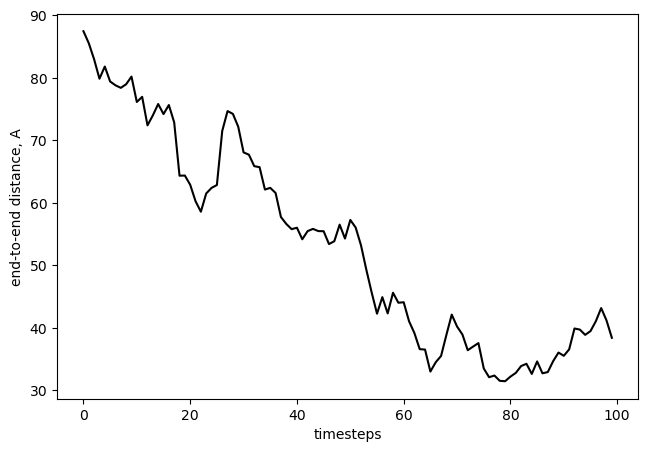

In [11]:
plt.figure(figsize=(7.5,5))

plt.plot( dist, '-k' )
plt.xlabel('timesteps')
plt.ylabel('end-to-end distance, A')

plt.show()

**[Ramachandran plot](https://en.wikipedia.org/wiki/Ramachandran_plot):**

We'll plot the phi vs psi angle for each residue for the last 30 steps (blue) and first 30 steps (black) of the simulation. This will allow us to see how the structure changes over the course of the simulation. n.b. if you change the length of the simulation, you'll need to change the numbers in the brackets referring to the last 30 steps.

<Figure size 640x480 with 0 Axes>

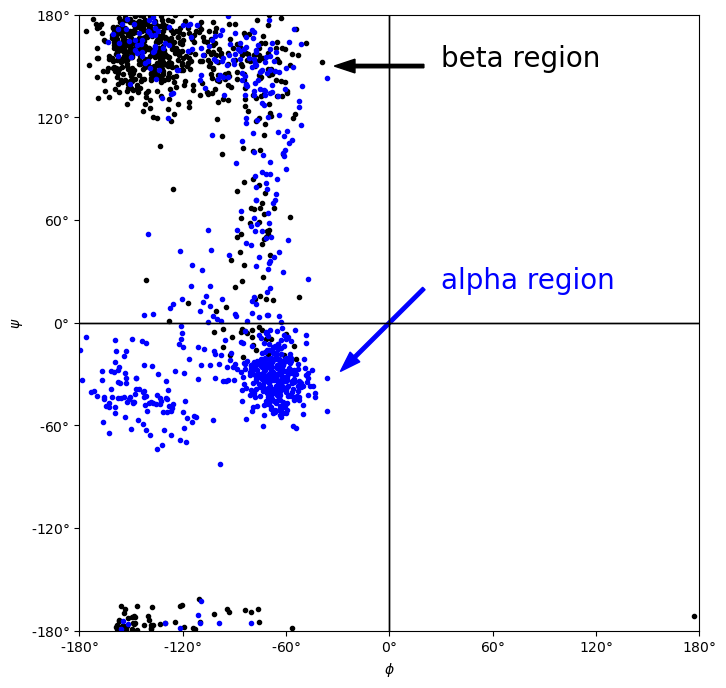

In [12]:
from MDAnalysis.analysis import dihedrals  ## module for dihedrals analysis
plt.clf()
ram1 = dihedrals.Ramachandran(sys).run(0,30) ## analyse for first 30 steps (black color)
ram2 = dihedrals.Ramachandran(sys).run(70,100) ## analyse for last 30 steps (blue color) n.b. you will need to change the numbers in brackets if you change the length of the simulation!

## ramachandran plot
fig, ax = plt.subplots(figsize=(8,8))
ram1.plot(ax=ax, color='k', marker='.')
ram2.plot(ax=ax, color='b', marker='.')
ax.arrow(20, 20, -40, -40, width=2, head_width=8, head_length=12, fc='b', ec='b')
ax.text(30, 20, 'alpha region', color='blue', fontsize=20)
ax.arrow(20, 150, -40, 0, width=2, head_width=8, head_length=12, fc='k', ec='k')
ax.text(30, 150, 'beta region', fontsize=20)
plt.show()

<hr>

## Bonus activities, if you have time!

- Investigate what happens if you change the temperature in your simulation. You can do this by changing the value in the line `temperature = 300*kelvin`.

- Try running a simulation/analysis of a polyglycine molecule and see what changes. You can do this by changing `pdb = PDBFile(pdb1_file)` to `pdb2_file` and re-running the cells.

Extra challenging:
- Try running a simulation/analysis of a molecule spelling your name with its amino acid code! You'll have to change `pdb3_file`, and you'll have to change the force field too or you'll get an error. You'll also have to change the residue for the end-to-end calculation from 25 to the length of your name (e.g. for `ARRAN.pdb` it'd be '5').